In [5]:
from distutils.command.install import install

import mne
import numpy as np
import pandas as pd
from matplotlib import matplotlib_fname
from matplotlib.pyplot import colormaps
from scipy.signal import coherence, hilbert

In [7]:
# ====== CONFIGURACIÓN ======
edf_path = r"C:\Users\V304-04\Documents\GitHub\Neurociencias-2026-1\S03_datasets\EEG_practica\chb01_01.edf"
sfreq_target = 256  # Frecuencia de muestreo a la que normalizamos (Hz)
fmin, fmax = 8, 13  # Banda alfa para la coherencia (puedes ajustar)
# ====== CARGA Y PREPROCESAMIENTO ======
raw = mne.io.read_raw_edf(edf_path, preload=True)
raw.resample(sfreq_target)
raw.filter(1., 45., fir_design='firwin')
data = raw.get_data()
ch_names = raw.info['ch_names']
n_channels = len(ch_names)

Extracting EDF parameters from C:\Users\V304-04\Documents\GitHub\Neurociencias-2026-1\S03_datasets\EEG_practica\chb01_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\V304-04\AppData\Local\Temp\ipykernel_5224\342209735.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


Sampling frequency of the instance is already 256.0, returning unmodified.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)



In [8]:
# ====== 1. MATRIZ DE CORRELACIÓN DE PEARSON ======
corr_matrix = np.corrcoef(data)
corr_df = pd.DataFrame(corr_matrix, index=ch_names, columns=ch_names)
corr_df.to_csv("connectivity_pearson.csv")

# ====== 2. MATRIZ DE COHERENCIA ESPECTRAL ======
coh_matrix = np.zeros((n_channels, n_channels))
for i in range(n_channels):
    for j in range(n_channels):
        f, Cxy = coherence(data[i], data[j], fs=sfreq_target, nperseg=sfreq_target*2)
        mask = (f >= fmin) & (f <= fmax)
        coh_matrix[i, j] = np.mean(Cxy[mask])

coh_df = pd.DataFrame(coh_matrix, index=ch_names, columns=ch_names)
coh_df.to_csv("connectivity_coherence.csv")

# ====== 3. MATRIZ DE PHASE LOCKING VALUE (PLV) ======
analytic_signal = hilbert(data)
phase_data = np.angle(analytic_signal)

plv_matrix = np.zeros((n_channels, n_channels))
for i in range(n_channels):
    for j in range(n_channels):
        phase_diff = phase_data[i] - phase_data[j]
        plv_matrix[i, j] = np.abs(np.sum(np.exp(1j * phase_diff)) / phase_diff.size)

plv_df = pd.DataFrame(plv_matrix, index=ch_names, columns=ch_names)
plv_df.to_csv("connectivity_plv.csv")

print("✅ Matrices de conectividad generadas:")
print("- connectivity_pearson.csv")
print("- connectivity_coherence.csv")
print("- connectivity_plv.csv")

✅ Matrices de conectividad generadas:
- connectivity_pearson.csv
- connectivity_coherence.csv
- connectivity_plv.csv


In [21]:

import seaborn as mon

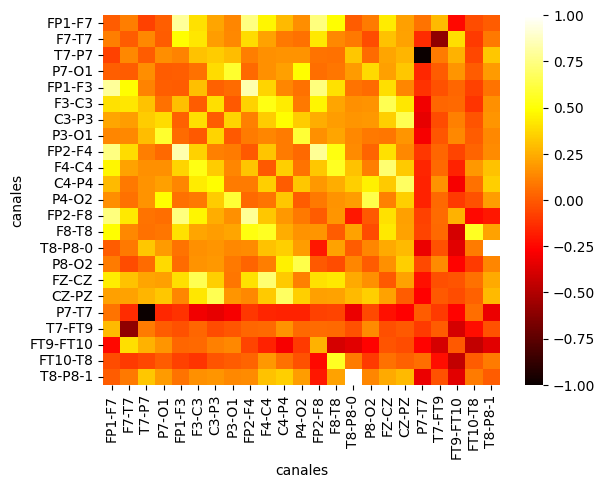

In [25]:
ax = mon.heatmap(corr_df - np.eye(len(corr_df)),
                 annot=False, cmap='hot', fmt='.2f',
                 xticklabels=corr_df.columns, yticklabels=corr_df.columns)
ax.set(xlabel='canales', ylabel='canales')
plt.show()

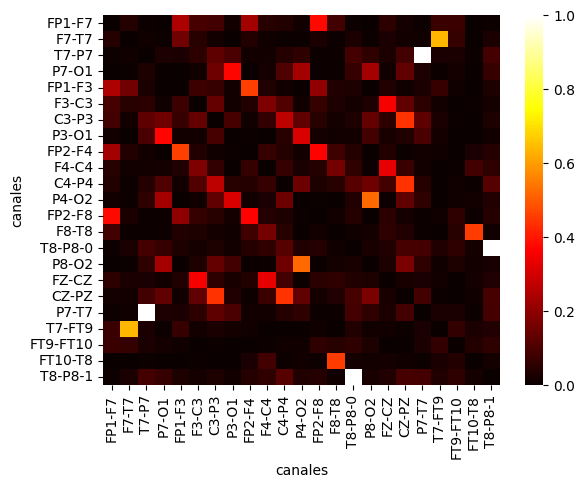

In [26]:
CohE = mon.heatmap(coh_df - np.eye(len(coh_df)),
                 annot=False, cmap='hot', fmt='.2f',
                 xticklabels=coh_df.columns, yticklabels=coh_df.columns)
CohE.set(xlabel='canales', ylabel='canales')
plt.show()

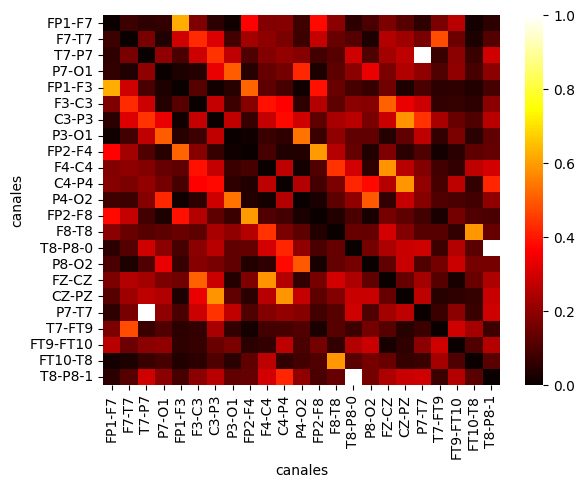

In [28]:
PLV = mon.heatmap(plv_df - np.eye(len(plv_df)),
                 annot=False, cmap='hot', fmt='.2f',
                 xticklabels=plv_df.columns, yticklabels=plv_df.columns)
PLV.set(xlabel='canales', ylabel='canales')
plt.show()

## Distribución